# Predicting Short-Term Stock Price Movements Using Machine Learning (Code)

## Setup

In [1]:
from google.colab import drive, runtime
import os
drive.mount('/content/drive', force_remount=True) # Mount Google Drive

PROJECT_PATH = "/content/drive/MyDrive/AML final project"
DATA_RAW_DIR = os.path.join(PROJECT_PATH, "data/raw") # Raw data dir
DATA_PROC_DIR = os.path.join(PROJECT_PATH, "data/processed") # Processed data dir
RESULT_DIR = os.path.join(PROJECT_PATH, "results") # Results dir

Mounted at /content/drive


In [2]:
print(os.listdir(DATA_PROC_DIR))

['AAPL.csv', 'GOOGL.csv', 'FB.csv', 'JPM.csv', 'MSFT.csv', 'IBM.csv', 'AMZN.csv', 'GE.csv', 'GS.csv', 'TSLA.csv']


In [3]:
import pandas as pd

FEATURE_COLS = [
'Close(t)',            # basic price
'Volume',              # volume
'MA10',                # short trend
'MA20',                # medium trend
'RSI',                 # momentum indicator
'MACD',                # momentum/trend change indicator
'MACD_EMA',            # signal line of MACD
'Volatility_10d',      # e.g., rolling std of return over 10 days
'Return_1d',           # previous day return
'Index_SP500_Return_1d',   # market context
'High_Low_Range',      # e.g., (High–Low)/Close yesterday
'Return_5d'            # 5-day return (momentum)
]

LABEL_COL = 'label_up_next'

csv_file_names = os.listdir(DATA_PROC_DIR)
tickers = []
dfs = {}

for fn in csv_file_names:
    df_proc = pd.read_csv(os.path.join(DATA_PROC_DIR, fn)).reset_index(drop=True)
    ticker = fn.split('.')[0]
    dfs[ticker] = df_proc
    tickers.append(ticker)

In [5]:
print(dfs.keys())
print(dfs['AAPL'].head())

dict_keys(['AAPL', 'GOOGL', 'FB', 'JPM', 'MSFT', 'IBM', 'AMZN', 'GE', 'GS', 'TSLA'])
   Close(t)     Volume   MA10   MA20        RSI      MACD  MACD_EMA  \
0      7.11  235211200  6.868  6.656  61.467621  0.179503  0.165416   
1      7.10  187421500  6.933  6.679  61.174093  0.188250  0.169982   
2      7.40  214265100  6.995  6.723  66.363516  0.216889  0.179364   
3      7.64  221095700  7.066  6.786  69.836867  0.256000  0.194691   
4      7.55  219508800  7.134  6.847  67.041136  0.276547  0.211062   

   Volatility_10d  Return_1d  Index_SP500_Return_1d  High_Low_Range  \
0        0.030474   0.058036               0.007176        0.056259   
1        0.028794  -0.001406              -0.003521        0.022535   
2        0.027487   0.042254               0.009977        0.040541   
3        0.028213   0.032432               0.004264        0.035340   
4        0.028460  -0.011780               0.000164        0.026490   

   Return_5d        Date  label_up_next  
0   0.014265  2005-

In [6]:

for ticker, df in dfs.items():
    if (df["Date"].is_monotonic_increasing):
        print(f"{ticker}: increases monotonically")
    else:
        print(f"{ticker}: does NOT increase monotonically")

    # Confirm each ticker has different date range
    print(f"Date min: {df["Date"].min()}, max: {df["Date"].max()}")

AAPL: increases monotonically
Date min: 2005-10-31, max: 2020-01-31
GOOGL: increases monotonically
Date min: 2007-10-31, max: 2020-01-31
FB: increases monotonically
Date min: 2015-10-30, max: 2020-01-31
JPM: increases monotonically
Date min: 2000-10-30, max: 2020-01-31
MSFT: increases monotonically
Date min: 2005-10-31, max: 2020-01-31
IBM: increases monotonically
Date min: 2000-10-30, max: 2020-01-31
AMZN: increases monotonically
Date min: 2010-11-01, max: 2020-01-31
GE: increases monotonically
Date min: 2000-10-30, max: 2020-01-31
GS: increases monotonically
Date min: 2005-10-31, max: 2020-01-31
TSLA: increases monotonically
Date min: 2015-10-30, max: 2020-01-31


## XG Boost

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix

xgb_results = {}

for ticker, df in dfs.items():
  # Feature list
  X = df[FEATURE_COLS].values
  y = df[LABEL_COL].values

  # Chronological 80/20 split
  cutoff = int(len(df) * 0.8)
  X_train, X_test = X[:cutoff], X[cutoff:]
  y_train, y_test = y[:cutoff], y[cutoff:]

  # XGBoost Model
  model = XGBClassifier(
      n_estimators=200,
      max_depth=4,
      learning_rate=0.05,
      subsample=0.9,
      colsample_bytree=0.9,
      eval_metric='logloss'
  )
  model.fit(X_train, y_train)

  # Predictions
  preds = model.predict(X_test)
  proba = model.predict_proba(X_test)[:, 1]

  # Get metrics
  acc = accuracy_score(y_test, preds)
  f1 = f1_score(y_test, preds)
  auc = roc_auc_score(y_test, proba)
  cm = confusion_matrix(y_test, preds)

  xgb_results[ticker] = {
      "accuracy": acc,
      "f1": f1,
      "auc": auc,
      "confusion_matrix": cm
  }

  # Print results!
  for ticker, r in xgb_results.items():
    print(f"=== {ticker} ===")
    print(f"Accuracy: {r['accuracy']:.4f}")
    print(f"F1 Score: {r['f1']:.4f}")
    print(f"AUC: {r['auc']:.4f}")
    print("Confusion Matrix:")
    print(r["confusion_matrix"])
    print()

=== AAPL ===
Accuracy: 0.4694
F1 Score: 0.4596
AUC: 0.4912
Confusion Matrix:
[[175 154]
 [227 162]]

=== AAPL ===
Accuracy: 0.4694
F1 Score: 0.4596
AUC: 0.4912
Confusion Matrix:
[[175 154]
 [227 162]]

=== GOOGL ===
Accuracy: 0.4814
F1 Score: 0.3651
AUC: 0.4715
Confusion Matrix:
[[205  88]
 [232  92]]

=== AAPL ===
Accuracy: 0.4694
F1 Score: 0.4596
AUC: 0.4912
Confusion Matrix:
[[175 154]
 [227 162]]

=== GOOGL ===
Accuracy: 0.4814
F1 Score: 0.3651
AUC: 0.4715
Confusion Matrix:
[[205  88]
 [232  92]]

=== FB ===
Accuracy: 0.4533
F1 Score: 0.4846
AUC: 0.4910
Confusion Matrix:
[[42 60]
 [57 55]]

=== AAPL ===
Accuracy: 0.4694
F1 Score: 0.4596
AUC: 0.4912
Confusion Matrix:
[[175 154]
 [227 162]]

=== GOOGL ===
Accuracy: 0.4814
F1 Score: 0.3651
AUC: 0.4715
Confusion Matrix:
[[205  88]
 [232  92]]

=== FB ===
Accuracy: 0.4533
F1 Score: 0.4846
AUC: 0.4910
Confusion Matrix:
[[42 60]
 [57 55]]

=== JPM ===
Accuracy: 0.4995
F1 Score: 0.1476
AUC: 0.5219
Confusion Matrix:
[[442  23]
 [462  42]]



### Ablation w/ XG Boost

In [7]:
FEATURE_GROUPS = {
    "full": FEATURE_COLS,
    "no_momentum": [
        'Close(t)', 'Volume', 'Volatility_10d',
        'Return_1d', 'Index_SP500_Return_1d',
        'High_Low_Range'
    ],
    "no_volatility": [
        'Close(t)', 'Volume', 'MA10', 'MA20',
        'RSI', 'MACD', 'MACD_EMA',
        'Return_1d', 'Index_SP500_Return_1d',
        'Return_5d'
    ],
    "no_market_context": [
        'Close(t)', 'Volume', 'MA10', 'MA20',
        'RSI', 'MACD', 'MACD_EMA',
        'Volatility_10d', 'Return_1d',
        'High_Low_Range', 'Return_5d'
    ]
}

In [ ]:
ablation_results = {}

for group_name, feature_list in FEATURE_GROUPS.items():
    ablation_results[group_name] = {}

    for ticker, df in dfs.items():
        X = df[feature_list].values
        y = df[LABEL_COL].values

        cutoff = int(len(df) * 0.8)
        X_train, X_test = X[:cutoff], X[cutoff:]
        y_train, y_test = y[:cutoff], y[cutoff:]

        model = XGBClassifier(
            n_estimators=200,
            max_depth=4,
            learning_rate=0.05,
            subsample=0.9,
            colsample_bytree=0.9,
            eval_metric='logloss'
        )
        model.fit(X_train, y_train)

        preds = model.predict(X_test)
        f1 = f1_score(y_test, preds)

        ablation_results[group_name][ticker] = f1

In [ ]:
import pandas as pd

# Aggregate results
rows = []
for group, ticker_scores in ablation_results.items():
    rows.append({
        "Feature Set": group,
        "Mean F1": sum(ticker_scores.values()) / len(ticker_scores)
    })

ablation_df = pd.DataFrame(rows)
ablation_df


,Feature Set,Mean F1
0,full,0.413891
1,no_momentum,0.450306
2,no_volatility,0.400755
3,no_market_context,0.399712


from matplotlib import pyplot as plt
ablation_df['Mean F1'].plot(kind='hist', bins=20, title='Mean F1')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
ablation_df.groupby('Feature Set').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
ablation_df['Mean F1'].plot(kind='line', figsize=(8, 4), title='Mean F1')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(ablation_df['Feature Set'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(ablation_df, x='Mean F1', y='Feature Set', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

## LSTM

In [4]:
# Split dataset to train/val/test per ticker

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

SEQ_LEN = 30

dfs_splitted = {}
for ticker, df in dfs.items():
    df = df.sort_values("Date").copy()
    df["Date"] = pd.to_datetime(df["Date"])
    df = df.sort_values("Date").reset_index(drop=True)
    df["ticker"] = ticker

    dates = df["Date"].unique()
    i_cutoff_train = int(len(dates) * 0.8)   # 80% train
    i_cutoff_val = int(len(dates) * 0.9)    # 10% val, 10% test
    dt_cutoff_train = dates[i_cutoff_train]
    dt_cutoff_val = dates[i_cutoff_val]

    df["split"] = "test"
    df.loc[df["Date"] <= dt_cutoff_val, "split"] = "val"
    df.loc[df["Date"] <= dt_cutoff_train, "split"] = "train"

    dfs_splitted[ticker] = df

for ticker, df in dfs_splitted.items():
    print(f"{ticker} all rows: {df.shape[0]}, trains: {df[df["split"] == "train"].shape[0]}, vals: {df[df["split"]=="val"].shape[0]}, tests: {df[df["split"] == "test"].shape[0]}")

AAPL all rows: 3587, trains: 2870, vals: 359, tests: 358
GOOGL all rows: 3084, trains: 2468, vals: 308, tests: 308
FB all rows: 1070, trains: 857, vals: 107, tests: 106
JPM all rows: 4843, trains: 3875, vals: 484, tests: 484
MSFT all rows: 3587, trains: 2870, vals: 359, tests: 358
IBM all rows: 4843, trains: 3875, vals: 484, tests: 484
AMZN all rows: 2328, trains: 1863, vals: 233, tests: 232
GE all rows: 4843, trains: 3875, vals: 484, tests: 484
GS all rows: 3587, trains: 2870, vals: 359, tests: 358
TSLA all rows: 1070, trains: 857, vals: 107, tests: 106


In [5]:
# Normalize by mean, variance from training dataset

dfs_splitted_scaled = {}
for ticker, df in dfs_splitted.items():
    # Fit scaler on train only
    scaler = StandardScaler()
    scaler.fit(df.loc[df["split"] == "train", FEATURE_COLS])

    # Scale train, test, val with stats from train
    df_scaled = df.copy()
    df_scaled[FEATURE_COLS] = scaler.transform(df_scaled[FEATURE_COLS])
    dfs_splitted_scaled[ticker] = df_scaled

In [6]:
# Define df -> splitted np arr conversion

def build_sequences_from_df(df_scaled, feature_cols, seq_len=SEQ_LEN):
    X_train_list, y_train_list = [], []
    X_val_list, y_val_list = [], []
    X_test_list,  y_test_list  = [], []

    df_sorted = df_scaled.sort_values("Date").reset_index(drop=True)

    feats  = df_sorted[feature_cols].values       # (T, F)
    labels = df_sorted[LABEL_COL].values          # (T,)
    splits = df_sorted["split"].values            # (T,)

    for i in range(seq_len - 1, len(df_sorted)):
        x_seq = feats[i - seq_len + 1 : i + 1]   # shape (seq_len, F)
        y     = labels[i]
        split = splits[i]  # label day split

        if split == "train":
            X_train_list.append(x_seq)
            y_train_list.append(y)
        elif split == "test":
            X_test_list.append(x_seq)
            y_test_list.append(y)
        else:
            X_val_list.append(x_seq)
            y_val_list.append(y)

    X_train = np.array(X_train_list, dtype=np.float32)
    y_train = np.array(y_train_list, dtype=np.float32)
    X_val   = np.array(X_val_list,   dtype=np.float32)
    y_val   = np.array(y_val_list,   dtype=np.float32)
    X_test  = np.array(X_test_list,  dtype=np.float32)
    y_test  = np.array(y_test_list,  dtype=np.float32)

    return X_train, y_train, X_val, y_val, X_test, y_test

In [7]:
# Create DataLoader for train, val, test

import torch
from torch.utils.data import Dataset, DataLoader

class SeqDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

def create_dataloaders(df, features, seq_len=SEQ_LEN):
    X_train_np, y_train_np, X_val_np, y_val_np, X_test_np, y_test_np = build_sequences_from_df(df, features, SEQ_LEN)

    train_dataset = SeqDataset(X_train_np, y_train_np)
    val_dataset = SeqDataset(X_val_np, y_val_np)
    test_dataset  = SeqDataset(X_test_np,  y_test_np)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)
    test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

loaders = {}

batch_size = 64

for ticker, df in dfs_splitted_scaled.items():
    train_loader, val_loader, test_loader = create_dataloaders(df, FEATURE_COLS, SEQ_LEN)

    loaders[ticker] = {}
    loaders[ticker]["train"] = train_loader
    loaders[ticker]["val"] = val_loader
    loaders[ticker]["test"] = test_loader


In [8]:
# Define model and epoch

import torch.nn as nn
from sklearn.metrics import accuracy_score

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=1, dropout=0.0):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0
        )
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        out, (h_n, c_n) = self.lstm(x)
        h_last = h_n[-1]
        logit = self.fc(h_last)
        return logit.squeeze(-1)

def run_epoch(model, loader, criterion, optimizer=None):
    if optimizer is None:
        model.eval()
    else:
        model.train()

    total_loss = 0.0
    all_probs, all_preds, all_labels = [], [], []

    for X_batch, y_batch in loader:
        X_batch = X_batch.to(DEVICE)
        y_batch = y_batch.to(DEVICE)

        logits = model(X_batch)
        loss = criterion(logits, y_batch)

        if optimizer is not None:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        total_loss += loss.item() * len(X_batch)

        probs = torch.sigmoid(logits).detach().cpu().numpy()
        preds = (probs >= 0.5).astype(int)
        labels = y_batch.detach().cpu().numpy().astype(int)

        all_probs.append(probs)
        all_preds.append(preds)
        all_labels.append(labels)

    all_probs = np.concatenate(all_probs)
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    avg_loss = total_loss / len(loader.dataset)
    acc = accuracy_score(all_labels, all_preds)

    return avg_loss, acc, all_probs, all_labels, all_preds

In [11]:
# Grid Search setup for tuning hyperparameter

from itertools import product

search_space = {
    "hidden_dim": [32, 64, 128],
    "num_layers": [1, 2], # dropout is applied between LSTM layers so if num_layers=1 dropout is ignored
    "dropout":    [0.0, 0.2], # dropout usually hurts LSTM
    "lr":         [1e-3, 3e-4], # Adam default is 1e-3
    "weight_decay":[0.0, 1e-4],
}

def make_model(input_dim, cfg):
    return LSTMClassifier(
        input_dim=input_dim,
        hidden_dim=int(cfg["hidden_dim"]),
        num_layers=int(cfg["num_layers"]),
        dropout=cfg["dropout"],
    ).to(DEVICE)


def build_grid_configs(search_space):
    """
    Returns: list[dict] of all hyperparameter combinations
    """
    keys = list(search_space.keys())
    values_product = list(product(*[search_space[k] for k in keys]))
    configs = []
    for vals in values_product:
        configs.append(dict(zip(keys, vals)))
    return configs

def train_with_early_stopping(model, train_loader, val_loader, cfg, max_epochs=50, patience=7):
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=cfg["lr"],
        weight_decay=cfg["weight_decay"],
    )

    best_state = None
    best_val_loss = float("inf")
    bad_epochs = 0

    history = []
    for epoch in range(1, max_epochs + 1):
        tr_loss, tr_acc, _, _, _ = run_epoch(model, train_loader, criterion, optimizer)
        va_loss, va_acc, _, _, _ = run_epoch(model, val_loader, criterion, optimizer=None)

        history.append(
            {"epoch": epoch, "train_loss": tr_loss, "train_acc": tr_acc, "val_loss": va_loss, "val_acc": va_acc}
        )

        if va_loss < best_val_loss - 1e-5: # Should improve at least more than 1e-5
            best_val_loss = va_loss
            best_state = copy.deepcopy(model.state_dict())
            bad_epochs = 0
        else:
            bad_epochs += 1
            if bad_epochs >= patience:
                break

    if best_state is not None:
        model.load_state_dict(best_state)

    return pd.DataFrame(history), best_val_loss

In [22]:
# Find best hyperparameters - define function, setup

import copy

cfgs = build_grid_configs(search_space)

def search_best_config(train_loader, val_loader, test_loader, input_dim):
    trial_rows = []
    best_cfg = None
    best_val = float("inf")
    best_model_state = None

    for i_cfg, cfg in enumerate(cfgs, start=1):
        model = make_model(input_dim, cfg)

        hist_df, val_loss = train_with_early_stopping(
            model,
            train_loader=train_loader,
            val_loader=val_loader,
            cfg=cfg,
            max_epochs=50,
            patience=7,
        )

        # Test metrics for reporting
        criterion = nn.BCEWithLogitsLoss()
        test_loss, test_acc, _, _, _ = run_epoch(model, test_loader, criterion, optimizer=None)

        trial_rows.append({
            **cfg,
            "best_val_loss": float(val_loss),
            "last_val_acc": float(hist_df["val_acc"].iloc[-1]),
            "test_loss": float(test_loss),
            "test_acc": float(test_acc),
            "epochs_ran": int(hist_df["epoch"].iloc[-1]),
        })

        if val_loss < best_val:
            best_val = val_loss
            best_cfg = cfg
            best_model_state = copy.deepcopy(model.state_dict())

        if i_cfg % 10 == 0:
            print(f"  Trial {i_cfg}: cfg={cfg} | best_val_loss={val_loss:.4f} | test_acc={test_acc:.3f}")

    training_report = pd.DataFrame(trial_rows).sort_values("best_val_loss").reset_index(drop=True)

    return best_cfg, training_report

In [ ]:
# Find best hyperparameters - execute

import copy

training_reports = {}
best_configs = {}

for ticker, train_val_test_dic in loaders.items():
    print(f"Ticker: {ticker}")

    train_loader = train_val_test_dic["train"]
    val_loader = train_val_test_dic["val"]
    test_loader = train_val_test_dic["test"]

    input_dim = len(FEATURE_COLS)

    best_cfg, training_report = search_best_config(train_loader, val_loader, test_loader, input_dim)
    training_reports[ticker] = training_report
    best_configs[ticker] = best_cfg

    print(f"Best for {ticker}: {best_cfg}")

In [57]:
# Save best hyperparamters per ticker to csv

import pandas as pd

best_cfg_df = pd.DataFrame()

for ticker, df in training_reports.items():
    row = {"ticker": ticker}
    rowdf = pd.DataFrame([row])
    rowdf = pd.concat([rowdf, df[search_space.keys()].iloc[0].to_frame().T], axis=1)
    best_cfg_df = pd.concat([best_cfg_df, rowdf], ignore_index=True)

LSTM_BEST_CFG_PATH = os.path.join(RESULT_DIR, "lstm_best_cfg.csv")
if not os.path.exists(LSTM_BEST_CFG_PATH):
    print("Best config file not exists. Saving a new file...")
    best_cfg_df.to_csv(LSTM_BEST_CFG_PATH)
else:
    print("Best config file exists. Skip saving")

Best config file exists. Skip saving


In [12]:
# Train 20 epochs with the best hyper parameters

import pandas as pd

LSTM_BEST_CFG_PATH = os.path.join(RESULT_DIR, "lstm_best_cfg.csv")
best_cfg_df = pd.read_csv(LSTM_BEST_CFG_PATH)
training_metric_dfs = {}
models = {}

for ticker, train_val_test_dic in loaders.items():
    print(f"Training started for {ticker}...")
    train_loader = train_val_test_dic["train"]
    test_loader = train_val_test_dic["test"]
    best_cfg = best_cfg_df[best_cfg_df['ticker']==ticker].iloc[0].to_dict()

    input_dim = len(FEATURE_COLS)

    # Train/test curve for best config
    best_model = make_model(input_dim, best_cfg)

    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(best_model.parameters(), lr=best_cfg["lr"], weight_decay=best_cfg["weight_decay"])

    df_curve = pd.DataFrame(columns=["train_loss", "train_acc", "test_loss", "test_acc"])
    num_epochs = 20
    for epoch in range(1, num_epochs + 1):
        train_loss, train_acc, _, _, _ = run_epoch(best_model, train_loader, criterion, optimizer)
        test_loss, test_acc, _, _, _ = run_epoch(best_model, test_loader, criterion, optimizer=None)
        df_curve.loc[len(df_curve)] = [train_loss, train_acc, test_loss, test_acc]

    models[ticker] = best_model
    training_metric_dfs[ticker] = df_curve

Training started for AAPL...
Training started for GOOGL...
Training started for FB...
Training started for JPM...
Training started for MSFT...
Training started for IBM...
Training started for AMZN...
Training started for GE...
Training started for GS...
Training started for TSLA...


In [13]:
# Run 1 epoch after training for error analysis

from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix

def get_err_metric(model, test_loader, criterion):

    test_loss, test_acc, test_probs, test_y, test_pred = run_epoch(
        model, test_loader, criterion, optimizer=None
    )

    tn, fp, fn, tp = confusion_matrix(test_y, test_pred).ravel()
    f1  = f1_score(test_y, test_pred)
    auc = roc_auc_score(test_y, test_probs)

    row = {
        "ticker": ticker,
        "accuracy": test_acc,
        "f1_score": f1,
        "auc": auc,
        "TP": tp, "FP": fp, "FN": fn, "TN": tn
    }

    return row

In [14]:
# Run 1 epoch after training for error analysis

from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
import torch.nn as nn

err_metric_df = pd.DataFrame()

criterion = nn.BCEWithLogitsLoss()

for ticker in tickers:
    row = get_err_metric(models[ticker], loaders[ticker]["test"], criterion)
    err_metric_df = pd.concat([err_metric_df, pd.DataFrame([row])], ignore_index=True)

In [18]:
# Save error metric

import os

err_metric_save_path = os.path.join(RESULT_DIR, "lstm_err_metric.csv")
if os.path.exists(err_metric_save_path):
    print("Error metric exists")
else:
    print("Saving error metric...")
    err_metric_df.to_csv(err_metric_save_path)

Saving error metric...


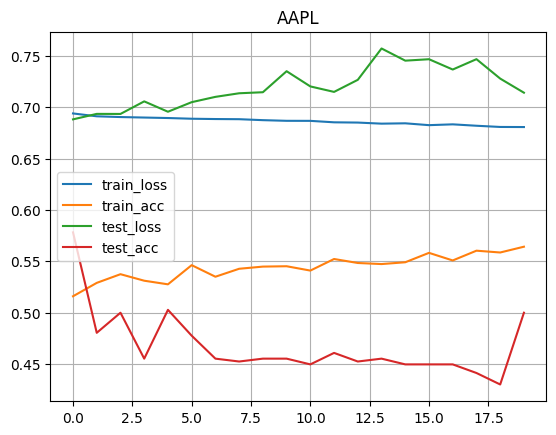

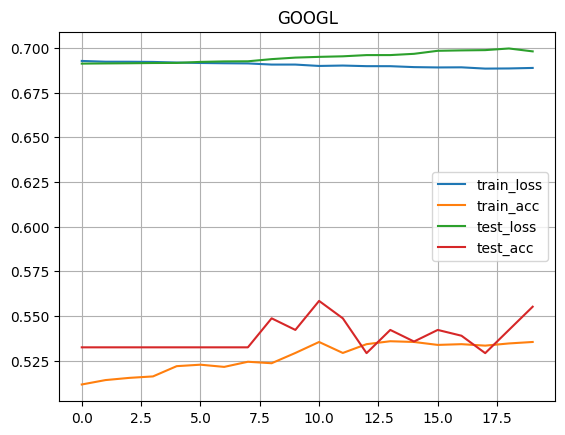

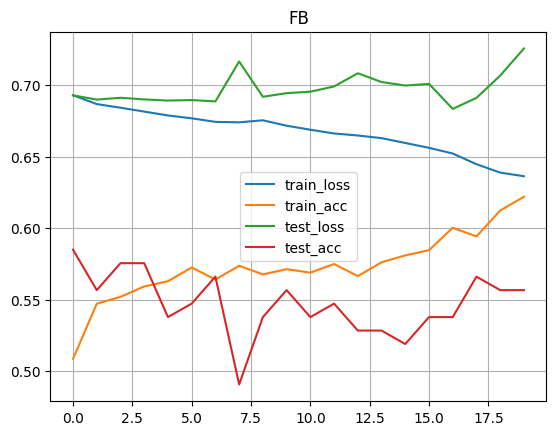

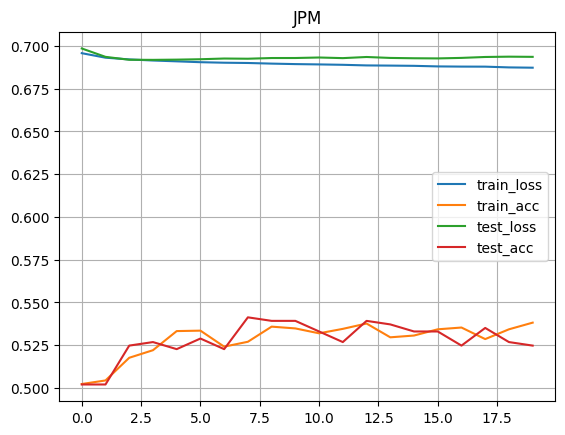

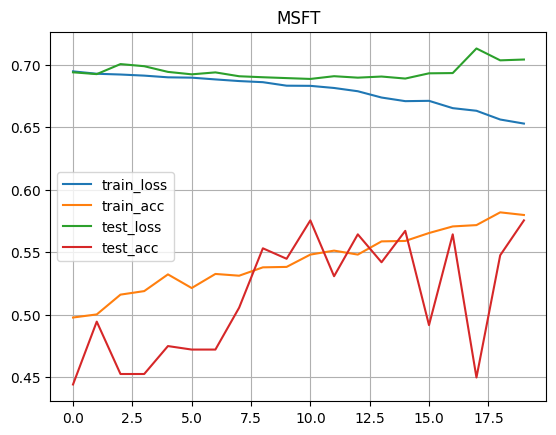

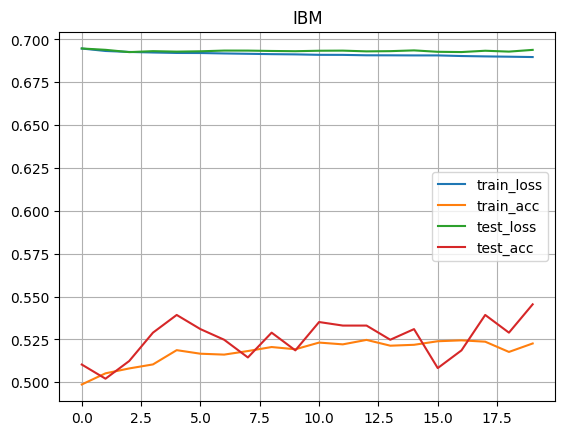

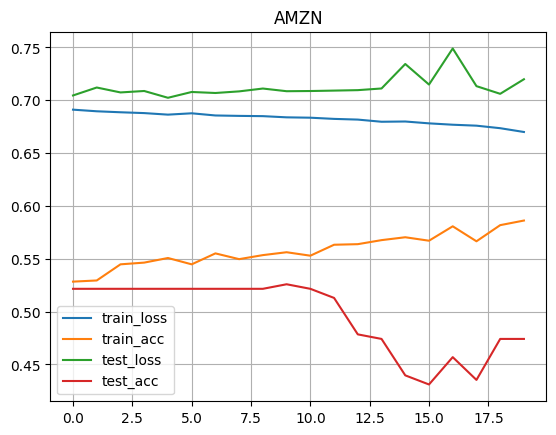

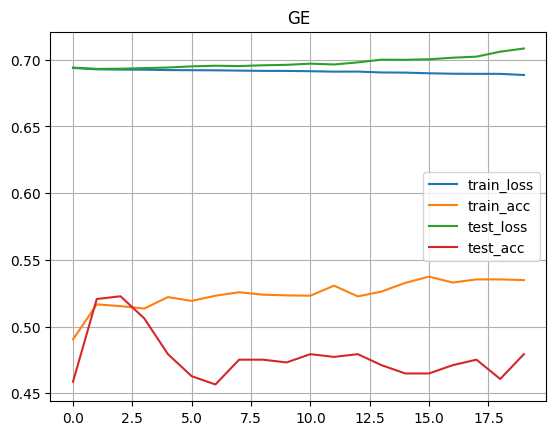

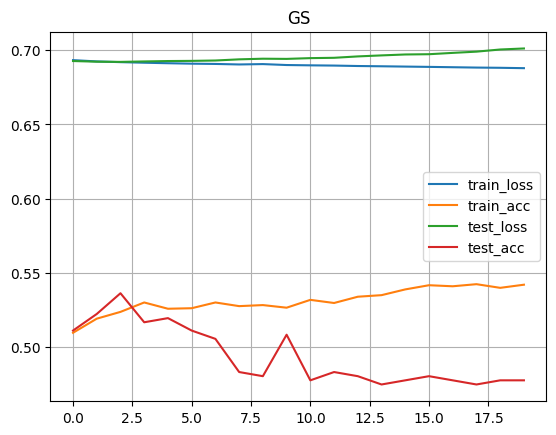

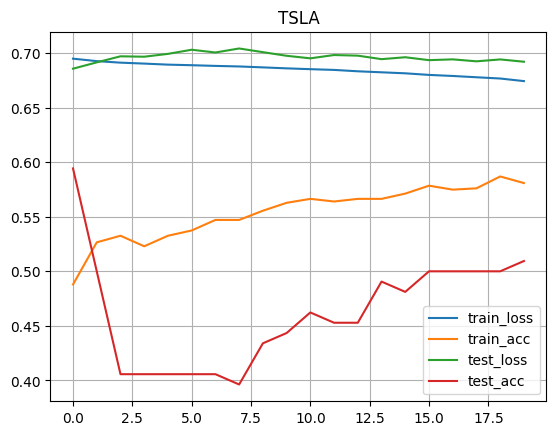

In [16]:
for ticker, df in training_metric_dfs.items():
    cols = df.columns.tolist()
    ax = df[cols].plot()
    ax.set_title(ticker)
    ax.grid(True)

In [155]:
for k, v in FEATURE_GROUPS.items():
    print(k, v)

full ['Close(t)', 'Volume', 'MA10', 'MA20', 'RSI', 'MACD', 'MACD_EMA', 'Volatility_10d', 'Return_1d', 'Index_SP500_Return_1d', 'High_Low_Range', 'Return_5d', 'Date']
no_momentum ['Close(t)', 'Volume', 'Volatility_10d', 'Return_1d', 'Index_SP500_Return_1d', 'High_Low_Range']
no_volatility ['Close(t)', 'Volume', 'MA10', 'MA20', 'RSI', 'MACD', 'MACD_EMA', 'Return_1d', 'Index_SP500_Return_1d', 'Return_5d']
no_market_context ['Close(t)', 'Volume', 'MA10', 'MA20', 'RSI', 'MACD', 'MACD_EMA', 'Volatility_10d', 'Return_1d', 'High_Low_Range', 'Return_5d']


In [16]:
nomom_features = FEATURE_GROUPS['no_momentum']
print(dfs_splitted_scaled['AAPL'].columns)
print(dfs_splitted_scaled['AAPL'][FEATURE_GROUPS['full']].columns)
print(dfs_splitted_scaled['AAPL'][nomom_features].shape)

Index(['Close(t)', 'Volume', 'MA10', 'MA20', 'RSI', 'MACD', 'MACD_EMA',
       'Volatility_10d', 'Return_1d', 'Index_SP500_Return_1d',
       'High_Low_Range', 'Return_5d', 'Date', 'label_up_next', 'ticker',
       'split'],
      dtype='object')
Index(['Close(t)', 'Volume', 'MA10', 'MA20', 'RSI', 'MACD', 'MACD_EMA',
       'Volatility_10d', 'Return_1d', 'Index_SP500_Return_1d',
       'High_Low_Range', 'Return_5d'],
      dtype='object')
(3587, 6)


In [23]:
# Ablation - Find best configs per ablation setup

best_cfg_per_ablation = {}
report_per_ablation = {}

for k, features in FEATURE_GROUPS.items():
    if k == "full":
        continue

    print(f"Ablation: {k}")

    loaders = {}
    features_len = len(features)
    batch_size = 64
    best_cfg_per_ablation[k] = {}

    for ticker, df in dfs_splitted_scaled.items():

        print(f"Ticker: {ticker}")
        df_ablated = df[features + ["Date", "ticker", "split", LABEL_COL]].copy()
        X_train_np, y_train_np, X_val_np, y_val_np, X_test_np, y_test_np = build_sequences_from_df(df_ablated, features, SEQ_LEN)
        print(ticker, X_train_np.shape, y_train_np.shape, X_val_np.shape, y_val_np.shape, X_test_np.shape, y_test_np.shape)

        train_dataset = SeqDataset(X_train_np, y_train_np)
        val_dataset = SeqDataset(X_val_np, y_val_np)
        test_dataset  = SeqDataset(X_test_np,  y_test_np)

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)
        test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

        best_cfg, report = search_best_config(train_loader, val_loader, test_loader, features_len)

        best_cfg_per_ablation[k][ticker] = best_cfg
        report_per_ablation[k][ticker] = report

Ablation: no_momentum
Ticker: AAPL
AAPL (2841, 30, 6) (2841,) (359, 30, 6) (359,) (358, 30, 6) (358,)
  Trial 10: cfg={'hidden_dim': 32, 'num_layers': 2, 'dropout': 0.0, 'lr': 0.001, 'weight_decay': 0.0001} | best_val_loss=0.6925 | test_acc=0.500
  Trial 20: cfg={'hidden_dim': 64, 'num_layers': 1, 'dropout': 0.0, 'lr': 0.0003, 'weight_decay': 0.0001} | best_val_loss=0.6920 | test_acc=0.553
  Trial 30: cfg={'hidden_dim': 64, 'num_layers': 2, 'dropout': 0.2, 'lr': 0.001, 'weight_decay': 0.0001} | best_val_loss=0.6930 | test_acc=0.520
  Trial 40: cfg={'hidden_dim': 128, 'num_layers': 1, 'dropout': 0.2, 'lr': 0.0003, 'weight_decay': 0.0001} | best_val_loss=0.6932 | test_acc=0.508
Ticker: GOOGL
GOOGL (2439, 30, 6) (2439,) (308, 30, 6) (308,) (308, 30, 6) (308,)
  Trial 10: cfg={'hidden_dim': 32, 'num_layers': 2, 'dropout': 0.0, 'lr': 0.001, 'weight_decay': 0.0001} | best_val_loss=0.6889 | test_acc=0.539
  Trial 20: cfg={'hidden_dim': 64, 'num_layers': 1, 'dropout': 0.0, 'lr': 0.0003, 'weigh

In [50]:
# Ablation - Save the acquired best configs

import os

for ablation_cat, reports in report_per_ablation.items():
    best_cfg_save_path = os.path.join(RESULT_DIR, f"lstm_best_cfg_{ablation_cat}.csv")
    if os.path.exists(best_cfg_save_path):
       print(f"Best cfg for {ablation_cat} exists")
       continue

    best_cfgs_df = pd.DataFrame()
    for ticker, report in reports.items():
        rowdf = pd.DataFrame([{"ticker": ticker}])
        best_cfg_df = report.iloc[0].to_frame().T
        rowdf = pd.concat([rowdf, best_cfg_df], axis=1)
        best_cfgs_df = pd.concat([best_cfgs_df, rowdf], ignore_index=True)

    print(f"Saving best cfg for {ablation_cat} at: {best_cfg_save_path}...")
    best_cfgs_df.to_csv(best_cfg_save_path)


Best cfg for no_momentum exists
Best cfg for no_volatility exists
Best cfg for no_market_context exists


In [80]:
# Ablation - Train 20 epochs with the best hyper parameters per ablation category

import pandas as pd

models_per_ablation = {}
training_metric_dfs_per_ablation = {}

for ablation_cat, features in FEATURE_GROUPS.items():
    if ablation_cat == "full":
        continue

    models_per_ablation[ablation_cat] = {}
    training_metric_dfs_per_ablation[ablation_cat] = {}

    best_cfg_save_path = os.path.join(RESULT_DIR, f"lstm_best_cfg_{ablation_cat}.csv")
    best_cfgs_df = pd.read_csv(best_cfg_save_path)

    best_cfg_df = pd.read_csv(best_cfg_save_path)

    for ticker in tickers:
        print(f"[{ablation_cat}] Training started for {ticker}...")

        train_loader, _, test_loader = create_dataloaders(dfs_splitted_scaled[ticker], features, SEQ_LEN)

        best_cfg = best_cfg_df[best_cfg_df['ticker']==ticker].iloc[0].to_dict()

        input_dim = len(features)

        # Train/test curve for best config
        best_model = make_model(input_dim, best_cfg)

        criterion = nn.BCEWithLogitsLoss()
        optimizer = torch.optim.Adam(best_model.parameters(), lr=best_cfg["lr"], weight_decay=best_cfg["weight_decay"])

        df_curve = pd.DataFrame(columns=["train_loss", "train_acc", "test_loss", "test_acc"])
        num_epochs = 20
        for epoch in range(1, num_epochs + 1):
            train_loss, train_acc, _, _, _ = run_epoch(best_model, train_loader, criterion, optimizer)
            test_loss, test_acc, _, _, _ = run_epoch(best_model, test_loader, criterion, optimizer=None)
            df_curve.loc[len(df_curve)] = [train_loss, train_acc, test_loss, test_acc]

        models_per_ablation[ablation_cat][ticker] = best_model
        training_metric_dfs_per_ablation[ablation_cat][ticker] = df_curve


[no_momentum] Training started for AAPL...
[no_momentum] Training started for GOOGL...
[no_momentum] Training started for FB...
[no_momentum] Training started for JPM...
[no_momentum] Training started for MSFT...
[no_momentum] Training started for IBM...
[no_momentum] Training started for AMZN...
[no_momentum] Training started for GE...
[no_momentum] Training started for GS...
[no_momentum] Training started for TSLA...
[no_volatility] Training started for AAPL...
[no_volatility] Training started for GOOGL...
[no_volatility] Training started for FB...
[no_volatility] Training started for JPM...
[no_volatility] Training started for MSFT...
[no_volatility] Training started for IBM...
[no_volatility] Training started for AMZN...
[no_volatility] Training started for GE...
[no_volatility] Training started for GS...
[no_volatility] Training started for TSLA...
[no_market_context] Training started for AAPL...
[no_market_context] Training started for GOOGL...
[no_market_context] Training starte

In [81]:
# Ablation - get error metrics

err_metric_df_by_ablation = {}

for ablation_cat, features in FEATURE_GROUPS.items():
    if ablation_cat == "full":
        continue

    err_metric_df = pd.DataFrame()

    for ticker, df in dfs_splitted_scaled.items():
        _, _, test_loader = create_dataloaders(df, features, SEQ_LEN)
        model = models_per_ablation[ablation_cat][ticker]
        criterion = nn.BCEWithLogitsLoss()

        row = get_err_metric(model, test_loader, criterion)
        err_metric_df = pd.concat([err_metric_df, pd.DataFrame([row])], ignore_index=True)

    err_metric_df_by_ablation[ablation_cat] = err_metric_df

    print(err_metric_df)

[no_momentum] Ticker: AAPL
[no_momentum] Ticker: GOOGL
[no_momentum] Ticker: FB
[no_momentum] Ticker: JPM
[no_momentum] Ticker: MSFT
[no_momentum] Ticker: IBM
[no_momentum] Ticker: AMZN
[no_momentum] Ticker: GE
[no_momentum] Ticker: GS
[no_momentum] Ticker: TSLA
  ticker  accuracy  f1_score       auc   TP   FP   FN   TN
0   AAPL  0.444134  0.123348  0.510764   14   15  184  145
1  GOOGL  0.542208  0.631854  0.497036  121   98   43   46
2     FB  0.556604  0.708075  0.561404   57   47    0    2
3    JPM  0.483471  0.273256  0.466592   47   54  196  187
4   MSFT  0.536313  0.578680  0.555379  114   77   89   78
5    IBM  0.500000  0.485106  0.519537  114   97  145  128
6   AMZN  0.521552  0.685552  0.507483  121  111    0    0
7     GE  0.466942  0.515038  0.475062  137  173   85   89
8     GS  0.491620  0.215517  0.510164   25   24  158  151
9   TSLA  0.452830  0.482143  0.461056   27   22   36   21
[no_volatility] Ticker: AAPL
[no_volatility] Ticker: GOOGL
[no_volatility] Ticker: FB
[n

In [83]:
# Ablation - Save error metric

for ablation_cat, err_metric_df in err_metric_df_by_ablation.items():
    err_metric_save_path = os.path.join(RESULT_DIR, f"lstm_err_metric_{ablation_cat}.csv")
    if os.path.exists(err_metric_save_path):
        print(f"Error metric for {ablation_cat} exists")
        continue
    print(f"Saving error metric for {ablation_cat}...")
    err_metric_df.to_csv(err_metric_save_path)

Error metric for no_momentum exists
Error metric for no_volatility exists
Error metric for no_market_context exists
